In [159]:
import sys
sys.path.append('euthyroid_sick_syndrome')
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils import *
import os

In [160]:
#carregando o dataset e utilizando as 8 features retornadas pelo RFE

dataset = pd.read_csv('../euthyroid_sick_syndrome/datasets/euthyroid/euthyroid_final_features.csv')

In [161]:
output_label_dataset = dataset['classification']  #1 = sick, 0 = normal
dataset = dataset[['age', 'on_thyroxine', 'query_hypothyroid', 'TSH', 'T3', 'TT4', 'T4U','FTI']]

#dataset = dataset[ ['age', 'sex', 'on_thyroxine', 'query_hypothyroid', 'query_hyperthyroid','TSH', 'T3', 'TT4', 'T4U', 'FTI']]

#dataset = dataset[ ['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'query_hypothyroid', 'query_hyperthyroid', 'goitre', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']]

#dataset = dataset[['age', 'on_thyroxine', 'on_antithyroid_medication', 'tumor', 'goitre','T3', 'TT4', 'T4U']]

#dataset = dataset[['age', 'sex', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick','tumor', 'T3', 'T4U']]

In [162]:
dataset.head()

,age,on_thyroxine,query_hypothyroid,TSH,T3,TT4,T4U,FTI
0,45,0,0,1.90,1.0,82.0,0.73,112.0
1,64,0,0,0.09,1.0,101.0,0.82,123.0
2,56,0,0,0.00,0.8,76.0,0.77,99.0
3,78,1,1,2.60,0.3,87.0,0.95,91.0
4,80,0,0,1.40,0.8,105.0,0.88,120.0


In [163]:
#fazendo o balanceamento dos dados
dataset_res, ouput_label = balance_dataset_smote(dataset, output_label_dataset, random_state=42, k_neighbors=5)


In [164]:
 # Dividindo os dados em treino e teste em 80% e 20% respectivamente
input_train, input_test, output_train, output_test = slipt_and_standardize_dataset(dataset=dataset_res, output_label=ouput_label, test_size=0.1)

In [165]:
input_train = np.asarray( input_train)
input_test = np.asarray( input_test)
output_train =np.asarray( output_train)
output_test =np.asarray( output_test)

In [166]:

# Modelo de rede perceptron multicamadas com uma camada oculta de 64 neurônios
# e camada de saída com 1 neurônios (1 classes)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, input_dim=dataset.shape[1], activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary() #visualizando o modelo



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 64)                576       
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [167]:
# Compile model
# Otimizador Adam com taxa de aprendizado de 0.01
opt = tf.keras.optimizers.Adam()

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# callback para salvar o modelo com menor perda no conjunto de validação
checkpoint_filepath = fname = os.path.sep.join(["euthyroid_sick_syndrome", "checkpoints"
	"weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
# early_stopping_loss
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)

# Treinamento do modelo 
history = model.fit(input_train, output_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[model_checkpoint_callback, early_stopping_loss])

Epoch 1/200
65/65 [==============================] - 1s 3ms/step - loss: 0.4977 - accuracy: 0.8144 - val_loss: 0.3307 - val_accuracy: 0.8936
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.2638 - accuracy: 0.9037 - val_loss: 0.2341 - val_accuracy: 0.9130
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.2041 - accuracy: 0.9177 - val_loss: 0.2117 - val_accuracy: 0.9246
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9267 - val_loss: 0.1988 - val_accuracy: 0.9284
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.1665 - accuracy: 0.9368 - val_loss: 0.1890 - val_accuracy: 0.9342
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9402 - val_loss: 0.1809 - val_accuracy: 0.9371
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.9470 - val_loss: 0.1790 - val_accuracy: 0.9313
Epoch 8/200
6

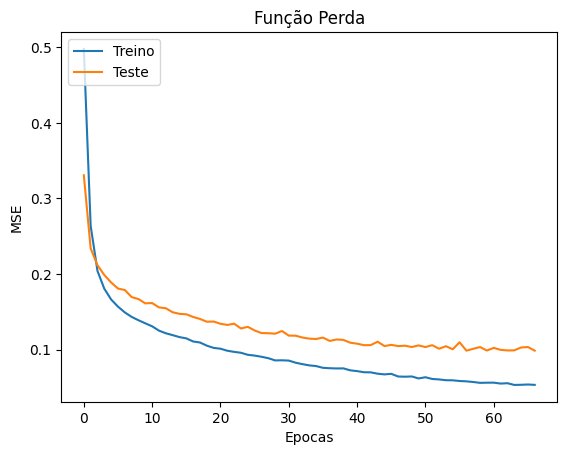

In [168]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função Perda')
plt.ylabel('MSE')
plt.xlabel('Epocas')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()


In [169]:

output_model = model.predict(input_test)


18/18 [==============================] - 0s 896us/step


In [170]:
accuracy(output_test, output_model.round())
precision(output_test, output_model.round())
recall(output_test, output_model.round())
f1(output_test, output_model.round())


A acurácia é de:  0.9790940766550522
A precisão é de:  0.9680851063829787
A pontuação de recall é de:  0.9891304347826086
A pontuação de F1 é de:  0.9784946236559139
